In [35]:
'''
DeepDA_verify is to verify DA output. 
It read proxy, prior, and posterior from DA outputs files and config file.
It calculates the statistics of the DA results and save the outputs.
By Mingsong Li
Penn State
2/17/2020
Updated Mar. 3. 2020
    for Monte Carlo simulations:
'''
from DeepDA_lib import modules_nc
from DeepDA_lib import DeepDA_psm
from scipy import stats
import shutil

import h5py
#import time
import yaml
import numpy as np
import pandas
import os
from netCDF4 import Dataset
from sys import platform as sys_pf
import matplotlib.pyplot as plt
if sys_pf == 'darwin':
    import matplotlib
    matplotlib.use("TkAgg")
    import matplotlib.pyplot as plt
%matplotlib inline

try:
    import bayspline
except ImportError as e1:
    print('Warning:', e1)
try:
    import bayspar
except ImportError as e2:
    print('Warning:', e2)
try:
    import bayfox
except ImportError as e3:
    print('Warning:', e3)
try:
    import baymag
except ImportError as e4:
    print('Warning:', e4)

print('>>  Import package => OKAY')
print('')
#####################    User defined start   #####################

reconi = 0  # 0 = prePETM; 1 = peakPETM

if reconi == 0:
    en = 'petmproxy3slices_v0.0.12.csv_petm11_v12_20200427_all_glassy_preP2_noCaCO3'    # prePETM
elif reconi == 1:
    en = 'petmproxy3slices_v0.0.12.csv_petm9_v12_20200427_all_glassy_pre_peak_noCaCO3' # peakPETM

dum_jmax = 36
dum_imax = 36
dum_ijmax = dum_imax * dum_jmax

AnalysisStd = True   # True: standardize; False: use raw analysis data

#####################    User defined end     #####################

config_name_f = "DeepDA_config.yml"
f = open(config_name_f, 'r')
yml_dict_f = yaml.load(f, Loader=yaml.FullLoader)
f.close()

dir_data_save = yml_dict_f['core']['wrkdir']

config_name = dir_data_save + '/' + en + '.yml'
f = open(config_name, 'r')
yml_dict = yaml.load(f, Loader=yaml.FullLoader)
f.close()
print('>>  Loading configuration file => OKAY')
print('')
# Read parameters from configurations
MCn = yml_dict['MonteCarlo']['number']
nens = yml_dict['core']['nens']

nexp = yml_dict['core']['nexp']
dir_data_save = yml_dict['core']['wrkdir']

recon_period = yml_dict['core']['recon_period']
recon_timescale = yml_dict['core']['recon_timescale_interval']
recon_period_full = np.arange(recon_period[0],recon_period[1]+1,recon_timescale)
recon_period_len = recon_period_full.shape[0]
recon_timescale = yml_dict['core']['recon_timescale_interval']
save_ens_full = yml_dict['core']['save_ens_full']
proxy_assim2 = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_assim2']
proxy_psm_type    = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_psm_type']
proxy_err_eval   = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_err_eval']
lon_label = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['lon_label']
lat_label = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['lat_label']

proxy_frac      = yml_dict['proxies']['proxy_frac']
prior_source = yml_dict['prior']['prior_source'] #
dum_lon_offset = yml_dict['prior'][prior_source]['dum_lon_offset'] # longitude offset
limit_hard_keys = list(yml_dict['prior'][prior_source]['limit_hard'].keys())
print(limit_hard_keys)

data_period_id    = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['data_period_id']
data_period_idstd = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['data_period_idstd']
recon_period = yml_dict['core']['recon_period']
recon_timescale = yml_dict['core']['recon_timescale_interval']
recon_period_full = np.arange(recon_period[0],recon_period[1]+1,recon_timescale)
recon_period_len = recon_period_full.shape[0]
geologic_age = yml_dict['core']['geologic_age']

# read preprior HDF5 file
dir_proxy_data = dir_data_save +'/'+ yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['dbversion']
proxy_err_eval = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_err_eval']

# read proxy raw file
proxy_dir = yml_dict['core']['proxy_dir']
proxy_rawfile = proxy_dir +'/'+ yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['dbversion']
# ========= dataset for plot =========
cGENIEGrid = yml_dict['core']['proj_dir'] + '/data_misc/cGENIEGrid.csv'
cGENIEGrid = pandas.read_csv(cGENIEGrid)
cGENIEGridB_lat36 = cGENIEGrid['lat']
cGENIEGridB_lon36 = cGENIEGrid['lon']
cGENIEGrid = cGENIEGrid.to_numpy()
#print('>>  OKAY.')

# Read global mean and plot to show results
########## Prior #########
prior_state_variable = yml_dict['prior'][prior_source]['state_variable']  # note: ['2d': xxx; '3d': xxx]
dum_lon_offset = yml_dict['prior'][prior_source]['dum_lon_offset'] # longitude offset
# ========= Monte Carlo =========
local_rad_list = yml_dict['core']['local_rad_list'] #
locRadn= len(local_rad_list)
local_rad_list = np.asarray(local_rad_list)
#print(local_rad_list)
#print(locRadn)
proxy_frac_list   = yml_dict['proxies']['proxy_frac']
proxy_fracn = len(proxy_frac_list)
proxy_frac_list = np.asarray(proxy_frac_list)

Rscale_list = yml_dict['core']['Rscale']
Rscalen = len(Rscale_list)
Rscale_list = np.asarray(Rscale_list)

# save prior variable list
prior_variable_dict = []  # variable list
prior_nc_file_list = []  # nc file list
prior_variable_dict_3d = []  # variable list
prior_nc_file_list_3d = []  # nc file list

for key, value in prior_state_variable.items():
    nc_keyvalue = prior_state_variable[key]['ncname']  # note: 2d dict
    print('>>  nc_keyvalue {}...'.format(nc_keyvalue))
    for key1, value1 in nc_keyvalue.items():
        print('>>  {}: {}'.format(key1,value1))
        for i in range(len(prior_state_variable[key][value1])):
            if key in ['2d']:
                prior_variable_dict.append(prior_state_variable[key][value1][i])
                prior_nc_file_list.append(key1+'/'+value1+'.nc')
            elif key in ['3d']:
                prior_variable_dict_3d.append(prior_state_variable[key][value1][i])
                prior_nc_file_list_3d.append(key1+'/'+value1+'.nc')

# variable list
prior_variable_len = len(prior_variable_dict)
prior_variable3d_len = len(prior_variable_dict_3d)
print('>>  Number of 2d prior variables is: {}. List:'.format(prior_variable_len))
print('      {}'.format(prior_variable_dict))
print('>>  Number of 3d prior variables is: {}. List:'.format(prior_variable3d_len))
print('      {}'.format(prior_variable_dict_3d))

MC_dir =  dir_data_save + '/' + en + '/'

Xa2d_full_np = np.full((locRadn,proxy_fracn,Rscalen,MCn*nens,prior_variable_len,recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
Xa2d_mean_np = np.full((locRadn,proxy_fracn,Rscalen,MCn,prior_variable_len,recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
Xa2d_std_np = np.full((locRadn,proxy_fracn,Rscalen,MCn,prior_variable_len,recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
# mean 
Xa2d_all_np = np.full((dum_jmax, dum_imax,locRadn,proxy_fracn,Rscalen,MCn, prior_variable_len, recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
Xa2d_allvar_np = np.full((dum_jmax, dum_imax, locRadn,proxy_fracn,Rscalen,MCn, prior_variable_len, recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
Xa2d_mean_np2 = np.full((locRadn,proxy_fracn,Rscalen,prior_variable_len,recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
Xa2d_std_np2 = np.full((locRadn,proxy_fracn,Rscalen,prior_variable_len,recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)

for locRadi in range(locRadn):
    locRad = local_rad_list[locRadi]
    if locRad is None:
        locRadv = 0 # for filename only
    else:
        locRadv = locRad
    for proxy_fraci in range(proxy_fracn):
        proxy_frac = proxy_frac_list[proxy_fraci]
        
        for Rscalei in range(Rscalen):
            Rscale = Rscale_list[Rscalei]
            for MCi in range(MCn):
                # NetCDF file name
                filename_short = '_loc_', str(locRadv),'_proxy_frac_', str(proxy_frac),'_Rscale_',str(Rscale),'_MC_' + str(MCi) 
                nc_filename = MC_dir + ''.join(filename_short) + '.nc'
                hdf5name    = MC_dir + ''.join(filename_short) + '.hdf5'
                
                print('>>  Read nc file: {}'.format(nc_filename))
                for Xa2d_vari in range(prior_variable_len):
                    Xa_full_name_vari = prior_variable_dict[Xa2d_vari] +'_Xa_full'
                    Xa_mean_name_vari = prior_variable_dict[Xa2d_vari] +'_Xa_mean'
                    Xa_variance_name_vari = prior_variable_dict[Xa2d_vari] +'_Xa_variance'
                    #print('>>  2d variable name {}'.format(Xa_mean_name_vari))
                    Xa_full_vari = Dataset(nc_filename).variables[Xa_full_name_vari][:]
                    Xa_mean_vari = Dataset(nc_filename).variables[Xa_mean_name_vari][:]
                    Xa_variance_vari = Dataset(nc_filename).variables[Xa_variance_name_vari][:]
                    
                    if prior_variable_dict[Xa2d_vari] in limit_hard_keys:
                        # some variables have hard limitation: e.g., CaCO3 = [0, 100]                        
                        lim_min = yml_dict['prior'][prior_source]['limit_hard'][prior_variable_dict[Xa2d_vari]]['lim_min']
                        lim_max = yml_dict['prior'][prior_source]['limit_hard'][prior_variable_dict[Xa2d_vari]]['lim_max']
                        #print('limit min {} and max {}'.format(lim_min, lim_max))
                        if lim_min:
                            if np.any(Xa_full_vari<lim_min):
                                Xa_full_vari[Xa_full_vari<lim_min] = lim_min
                                Xa_mean_vari = np.mean(Xa_full_vari,axis=2)
                                Xa_variance_vari = np.var(Xa_full_vari,axis=2)
                                print('>>    Force {} value to be >= {}'.format(prior_variable_dict[Xa2d_vari],lim_min))
                        if lim_max:
                            if np.any(Xa_full_vari>lim_max):
                                Xa_full_vari[Xa_full_vari>lim_max] = lim_max
                                Xa_mean_vari = np.mean(Xa_full_vari,axis=2)
                                Xa_variance_vari = np.var(Xa_full_vari,axis=2)
                                print('>>    Force {} value to be <= {}'.format(prior_variable_dict[Xa2d_vari], lim_max))
                                
                    for reconi in range(recon_period_len):
                        
                        Xa_full_reconi = Xa_full_vari[:,:,:,0,reconi].reshape((dum_ijmax,nens))
                        Xa_full_reconi_mean = np.nanmean(Xa_full_reconi,axis=0)
                        
                        Xa_mean_reconi = Xa_mean_vari[:,:,0,reconi]
                        Xa2d_all_np[:,:,locRadi,proxy_fraci,Rscalei,MCi,Xa2d_vari,reconi] = np.copy(Xa_mean_vari[:,:,0,reconi])
                        Xa_mean_reconi_mean = np.nanmean(Xa_mean_reconi)

                        Xa_variance_reconi = Xa_variance_vari[:,:,0,reconi]
                        Xa2d_allvar_np[:,:,locRadi,proxy_fraci,Rscalei,MCi,Xa2d_vari,reconi] = Xa_variance_vari[:,:,0,reconi]
                        Xa_std_reconi_mean = np.sqrt(np.nanmean(Xa_variance_reconi))
                        
                        #print('>>  reconi = {}, mean is {}, std is {}'.format(reconi, Xa_mean_reconi_mean, Xa_std_reconi_mean))
                        Xa2d_full_np[locRadi,proxy_fraci,Rscalei,MCi*nens:(MCi+1)*nens,Xa2d_vari,reconi] = Xa_full_reconi_mean
                        Xa2d_mean_np[locRadi,proxy_fraci,Rscalei,MCi,Xa2d_vari,reconi] = Xa_mean_reconi_mean
                        Xa2d_std_np[locRadi,proxy_fraci,Rscalei,MCi,Xa2d_vari,reconi] = Xa_std_reconi_mean
            print('First variable: all MC mean')
            print(Xa2d_mean_np[locRadi,proxy_fraci,Rscalei,:,0,0])
            
            Xa2d_all_np = np.ma.masked_where(Xa2d_all_np > 9.0e+36, Xa2d_all_np)
            Xa2d_allvar_np = np.ma.masked_where(Xa2d_all_np > 9.0e+36, Xa2d_allvar_np)
            for Xa2d_vari in range(prior_variable_len):
                for reconi in range(recon_period_len):
                    Xa2d_mean_np2[locRadi,proxy_fraci,Rscalei,Xa2d_vari,reconi] = np.nanmean(Xa2d_all_np[:,:,locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi])
                    Xa2d_std_np2[locRadi,proxy_fraci,Rscalei,Xa2d_vari,reconi] = np.sqrt(np.nanmean(Xa2d_allvar_np[:,:,locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi]))
            
            np.set_printoptions(precision=6, suppress=True)
            print('All variable. Mean of variables x reconi')
            print('{}'.format(Xa2d_mean_np2[locRadi,proxy_fraci,Rscalei,:,:]))
            #print('std  of variables x reconi')
            #print('{}'.format(Xa2d_std_np2))
#print('mean of variables x reconi'.format(Xa2d_mean_np2))
#print('{}'.format(Xa2d_mean_np2))
#print('std  of variables x reconi'.format(Xa2d_std_np2))
#print('{}'.format(Xa2d_std_np2))

>>  Import package => OKAY

>>  Loading configuration file => OKAY

['sed_CaCO3', 'atm_pCO2']
>>  nc_keyvalue {'biogem': 'fields_biogem_2d', 'sedgem': 'fields_sedgem_2d'}...
>>  biogem: fields_biogem_2d
>>  sedgem: fields_sedgem_2d
>>  nc_keyvalue {'biogem': 'fields_biogem_3d'}...
>>  biogem: fields_biogem_3d
>>  Number of 2d prior variables is: 8. List:
      ['ocn_sur_temp', 'atm_pCO2', 'ocn_sur_sal', 'misc_pH', 'carb_sur_ohm_cal', 'sed_CaCO3', 'sed_CaCO3_13C', 'carb_ohm_cal']
>>  Number of 3d prior variables is: 0. List:
      []
>>  Read nc file: /mnt/d/DeepDA/wrk/petmproxy3slices_v0.0.12.csv_petm11_v12_20200427_all_glassy_preP2_noCaCO3/_loc_0_proxy_frac_0.7_Rscale_1.0_MC_0.nc
>>    Force sed_CaCO3 value to be <= 100.0
>>  Read nc file: /mnt/d/DeepDA/wrk/petmproxy3slices_v0.0.12.csv_petm11_v12_20200427_all_glassy_preP2_noCaCO3/_loc_0_proxy_frac_0.7_Rscale_1.0_MC_1.nc
>>    Force sed_CaCO3 value to be <= 100.0
>>  Read nc file: /mnt/d/DeepDA/wrk/petmproxy3slices_v0.0.12.csv_petm11_v

In [36]:
print(prior_nc_file_list[2])

biogem/fields_biogem_2d.nc


In [37]:
'''
Read proxy, calculate temperate, save output in lmwrk/wrk/ folder
Use this as 'data', use prior, and posterior for comparison
'''
print(' ########## Read proxies database ########## ')

### read proxies database ###
proxies = pandas.read_csv(proxy_rawfile)
proxies_len0 = len(proxies)

print('{}'.format(proxy_rawfile))
print('len is {}'.format(proxies_len0))

proxy_order       = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_order']
proxy_blacklist   = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_blacklist']
proxy_list = [item for item in proxy_order if item not in proxy_blacklist]
proxy_d18o_glassy  = yml_dict['proxies']['proxy_d18o_glassy']
proxy_assim3 = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_assim3']
data_glassy_label_blacklist = proxy_assim3['Marine sediments_d18o_pooled_glassy']

proxy_select_0 = 0

for j in range(proxies_len0):
    # Read proxy type from the database
    data_psm_type = proxies['Proxy'][j]
    # initial default 0 : this proxy is not included
    data_assimilate_i = 0
    for jlist in range(len(proxy_list)):
        if data_psm_type in proxy_assim2[proxy_list[jlist]]:
            # find and save this proxy
            data_assimilate_i = 1
    if data_assimilate_i == 1:
        #print('>>    file {}, {} included'.format(proxies.loc[j,'File'], data_psm_type))
        if proxy_select_0 == 0:
            proxy_select0 = proxies.iloc[[j]]
            proxy_select0 = proxy_select0.reset_index(drop=True) # reset_index, avoid index error
            proxy_select_0 = 1
        else:
            #proxy_select.append(proxies.iloc[[j]])
            proxy_select0 = proxy_select0.append(proxies.iloc[[j]], ignore_index=True)
#print('proxy selected {}'.format(proxy_select0))

proxies_select_len0 = len(proxy_select0)
print('>>  Proxy: selected proxy dataset number {}: those in blacklist removed'.format(proxies_select_len0))

### check glassy only data or not
proxy_select_0 = 0
if proxy_d18o_glassy:
    for jj in range(proxies_select_len0):
        data_glassy_label = proxy_select0['Glassy'][jj]
        if data_glassy_label not in data_glassy_label_blacklist:
            if proxy_select_0 == 0:
                proxy_select = proxy_select0.iloc[[jj]]
                proxy_select = proxy_select.reset_index(drop=True) # reset_index, avoid index error
                proxy_select_0 = 1
            else:
                proxy_select = proxy_select.append(proxy_select0.iloc[[jj]], ignore_index=True)

    #print(proxy_select)
    proxies_select_len0 = len(proxy_select)
    print('>>  Proxy: selected proxy dataset number {}: remove those unknown/frosty'.format(proxies_select_len0))
else:
    proxy_select = proxy_select0.copy()
#print(proxy_select)

 ########## Read proxies database ########## 
/mnt/c/Users/mul450/Dropbox/git/deepDA/mlwrk/proxy/petmproxy3slices_v0.0.12.csv
len is 90
>>  Proxy: selected proxy dataset number 55: those in blacklist removed
>>  Proxy: selected proxy dataset number 41: remove those unknown/frosty


In [33]:
#
# prep Mg/Ca for baymag and mgca_et.m
#


proxy_psm_type_dict = {}
#    0                1              2          3        4        5        6        7
# carb_ohm_cal carb_sur_ohm_cal ocn_sur_sal misc_pH misc_pH_std clean prePETMmean prePETMstd
mgca_para = np.full((proxies_select_len0,8),np.nan)  # matrix for data saving
variable_id_mg = np.array([7,4,2,3])  # list variable id  omega,sur_ohm,salinity,pH
#Xa2d_all_np[dum_jmax, dum_imax,locRadn,proxy_fracn,Rscalen,MCn, prior_variable_len, recon_period_len]

if reconi == 0:
    reconidname = 'prePETMmean'
    reconidstdname = 'prePETMstd'
else:
    reconidname = 'peakPETM'
    reconidstdname = 'peakPETMstd'
#Xavari = Xa2d_all_np[:, :,0,0,0,:, 7, reconi]
#print(Xavari.shape)

#>>  Number of 2d prior variables is: 8.
#      List:
#     0   biogem/fields_biogem_2d.nc/ocn_sur_temp
#     1   biogem/fields_biogem_2d.nc/atm_pCO2
#     2   biogem/fields_biogem_2d.nc/ocn_sur_sal
#     3   biogem/fields_biogem_2d.nc/misc_pH
#     4   biogem/fields_biogem_2d.nc/carb_sur_ohm_cal
#     5   sedgem/fields_sedgem_2d.nc/sed_CaCO3
#     6   sedgem/fields_sedgem_2d.nc/sed_CaCO3_13C
#     7   sedgem/fields_sedgem_2d.nc/carb_ohm_cal

for j in range(proxies_select_len0):
    # Read proxy type from the database
    data_psm_type = proxy_select['Proxy'][j]
    # Read allowed proxy from the DTDA-config.yml
    data_psm_type_find = 0
    for key, value in proxy_assim2.items():
        # check this proxy type exist or not, and how many times it occurrs
        if data_psm_type in proxy_assim2[key]:
            data_psm_type_find = data_psm_type_find + 1
    if data_psm_type_find == 1:
        for key, value in proxy_psm_type.items():
            if data_psm_type in proxy_assim2[key]:
                data_psm_key = key
        proxy_psm_type_i = proxy_psm_type[data_psm_key]
        proxy_psm_type_dict[j] =proxy_psm_type_i
        print('>>  {}. PSM for {} is {}'.format(j, data_psm_type,proxy_psm_type_i))
        
    # NOW estimate SST from proxy
    # read lon lat for each line of proxy
    dum_lat = proxies[lat_label][j]  # (paleo)latitude of this site
    dum_lon = proxies[lon_label][j]  # (paleo)longitude of this site
    lonlat = modules_nc.cal_find_ij(dum_lon,dum_lat,dum_lon_offset,dum_imax,dum_jmax)
    # output [lon, lat], lon ranges from 0 (-180) to 35 (180), lat ranges from 0 (-90) to 35 (90)
    Filei = proxies['File'][j]
    
    ## mean 
    #Xa2d_all_np =    np.full((dum_jmax, dum_imax,locRadn,proxy_fracn,Rscalen,MCn, prior_variable_len, recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
    #Xa2d_allvar_np = np.full((dum_jmax, dum_imax,locRadn,proxy_fracn,Rscalen,MCn, prior_variable_len, recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)

    if proxy_psm_type_i in ['bayesreg_mgca_pooled_red','bayesreg_mgca_pooled_bcp']:
        for i in range(len(variable_id_mg)):
            
            Xavari = Xa2d_all_np[:,:,0,0,0,:,variable_id_mg[i],reconi]
            mgca_para[j][i] = np.mean(Xavari[lonlat[1], lonlat[0],:])
            if i == 3:
                Xavarii = Xa2d_allvar_np[:,:,0,0,0,:,variable_id_mg[i],reconi]
                mgca_para[j][i+1] = np.sqrt(np.mean(Xavarii[lonlat[1], lonlat[0],:])) # save std of pH
            print('  variable {} in {} value {}'.format(prior_variable_dict[variable_id_mg[i]],prior_nc_file_list[variable_id_mg[i]], mgca_para[j][i]))
            
        red = proxy_select['mg_bcp_red'][j]
        if red in ['mg_red']:
            mgca_para[j][5] = 1
        if red in ['mg_bcp']:
            mgca_para[j][5] = 0
        mgca_para[j][6] = proxy_select[reconidname][j]
        mgca_para[j][7] = proxy_select[reconidstdname][j]
print(mgca_para)

cols = ['carb_ohm_cal','carb_sur_ohm_cal', 'ocn_sur_sal', 'misc_pH','misc_pH_std', 'clean',reconidname,reconidstdname]
df = pandas.DataFrame(mgca_para,columns=cols)
dirdir = yml_dict['core']['proj_dir']+'/proxy/' + 'petmproxy3slices_v0.0.12_sst_'+reconidname+'_mgca.csv'
df.to_csv(dirdir,index = False)

>>  0. PSM for tex86 is bayesreg_tex86
>>  1. PSM for d18o_m.subb is bayesreg_d18o_pooled
>>  2. PSM for mgca_m.subb:barker is bayesreg_mgca_pooled_bcp
  variable carb_ohm_cal in sedgem/fields_sedgem_2d.nc value 0.5526841700077056
  variable carb_sur_ohm_cal in biogem/fields_biogem_2d.nc value 1.4150398433208466
  variable ocn_sur_sal in biogem/fields_biogem_2d.nc value 33.33970413208008
  variable misc_pH in biogem/fields_biogem_2d.nc value 7.114457654953003
>>  3. PSM for mgca_acarinina:barker is bayesreg_mgca_pooled_bcp
  variable carb_ohm_cal in sedgem/fields_sedgem_2d.nc value 0.34712952077388765
  variable carb_sur_ohm_cal in biogem/fields_biogem_2d.nc value 1.8360522210597991
  variable ocn_sur_sal in biogem/fields_biogem_2d.nc value 34.631319999694824
  variable misc_pH in biogem/fields_biogem_2d.nc value 7.12820520401001
>>  4. PSM for mgca_m.subb:barker is bayesreg_mgca_pooled_bcp
  variable carb_ohm_cal in sedgem/fields_sedgem_2d.nc value 0.34712952077388765
  variable carb_

In [ ]:
print('OKAY STOP HERE')


In [51]:
# calculate SST for each proxy
data_periodn = len(data_period_id)
print('{} len is {}'.format(data_period_id, data_periodn))
proxy_psm_type_dict = {}
recon_sst = np.full((proxies_select_len0,data_periodn*2),np.nan)

for j in range(proxies_select_len0):
    # Read proxy type from the database
    data_psm_type = proxy_select['Proxy'][j]
    # Read allowed proxy from the DTDA-config.yml
    data_psm_type_find = 0
    for key, value in proxy_assim2.items():
        # check this proxy type exist or not, and how many times it occurrs
        if data_psm_type in proxy_assim2[key]:
            data_psm_type_find = data_psm_type_find + 1
    if data_psm_type_find == 1:
        for key, value in proxy_psm_type.items():
            if data_psm_type in proxy_assim2[key]:
                data_psm_key = key
        proxy_psm_type_i = proxy_psm_type[data_psm_key]
        proxy_psm_type_dict[j] =proxy_psm_type_i
        print('>>  {}. PSM for {} is {}'.format(j, data_psm_type,proxy_psm_type_i))

    # Now PSM type has been found. Let's precal Ye
    if proxy_psm_type_i in ['bayesreg_mgca_pooled_red','bayesreg_mgca_pooled_bcp']:
        data_psm_mgca_find = 1
        
    # NOW estimate SST from proxy
    # read lon lat for each line of proxy
    dum_lat = proxies[lat_label][j]  # (paleo)latitude of this site
    dum_lon = proxies[lon_label][j]  # (paleo)longitude of this site
    lonlat = modules_nc.cal_find_ij(dum_lon,dum_lat,dum_lon_offset,dum_imax,dum_jmax)
    # output [lon, lat], lon ranges from 0 (-180) to 35 (180), lat ranges from 0 (-90) to 35 (90)
    Filei = proxies['File'][j]
    # find 1d grid location
    #lonlati = lonlat[1] * dum_jmax + lonlat[0] + psm_required_variable_key_index * dum_ijmax
    # read prior
    #prior_1grid = np.copy(Xb[lonlati,:])   # priors
    
    for periodi in range(data_periodn):
        periodid = data_period_id[periodi]
        value_i = proxy_select[periodid][j]
        if proxy_psm_type_i in ['bayesreg_d18o_pooled']:
            d18o_localsw = DeepDA_psm.d18o_localsw(abs(dum_lat))
            prediction = bayfox.predict_seatemp(value_i, d18osw=d18o_localsw, prior_mean=30, prior_std=10)
            mye   = np.mean(prediction.ensemble, axis = 1)[0]
            varye = np.std(prediction.ensemble, ddof=1)
            recon_sst[j][periodi*2] = mye
            recon_sst[j][periodi*2+1] = varye
            print('        {}, raw {:.6f} mean {:.6f} std {:.6f}'.format(periodid, value_i, mye, varye))
            
        if proxy_psm_type_i in ['bayesreg_tex86']:
            search_tolerance = 1.0
            try:
                prediction = bayspar.predict_seatemp_analog(value_i,
                                prior_mean = 30, prior_std = 20, 
                                search_tol = search_tolerance,
                                temptype='sst',nens=1000)
            except:
                search_tolerance = 5.0
                value_i2 = np.array([value_i, value_i])
                prediction = bayspar.predict_seatemp_analog(value_i2,
                                prior_mean = 30, prior_std = 20, 
                                search_tol = search_tolerance,
                                temptype='sst',nens=1000)
                print(prediction.ensemble.shape)
            try:
                mye   = np.mean(prediction.ensemble[0,:,:], axis = 1)[0]
                varye = np.std(prediction.ensemble[0,:,:], ddof=1)
                recon_sst[j][periodi*2] = mye
                recon_sst[j][periodi*2+1] = varye
                print('        {}, raw {:.6f} mean {:.6f} std {:.6f}'.format(periodid, value_i, mye, varye))
            except:
                print('        {} {} raw {:.6f} error'.format(Filei, proxy_psm_type_i,value_i))

  5%|▌         | 4/80 [00:00<00:02, 32.58it/s]

['prePETMmean', 'peakPETM', 'PETMmean', 'postPETMmean'] len is 4
>>  0. PSM for tex86 is bayesreg_tex86


  5%|▌         | 4/80 [00:00<00:02, 34.43it/s]

(2, 80, 1000)
        prePETMmean, raw 0.608182 mean 23.598193 std 6.876683


  5%|▌         | 4/80 [00:00<00:02, 33.50it/s]

(2, 80, 1000)
        peakPETM, raw 0.630000 mean 24.549404 std 7.275977


  5%|▌         | 4/80 [00:00<00:02, 32.41it/s]

(2, 80, 1000)
        PETMmean, raw 0.616316 mean 23.962047 std 7.033290


  5%|▌         | 4/80 [00:00<00:02, 33.36it/s]

(2, 80, 1000)
        postPETMmean, raw 0.555333 mean 21.053612 std 6.013716
>>  1. PSM for d18o_m.subb is bayesreg_d18o_pooled
        prePETMmean, raw -1.655826 mean 25.044349 std 2.303015
        peakPETM, raw -2.571895 mean 28.773717 std 2.322343
        PETMmean, raw -2.405783 mean 28.112979 std 2.284948
        postPETMmean, raw -2.153799 mean 27.110177 std 2.313977
>>  2. PSM for mgca_m.subb:barker is bayesreg_mgca_pooled_bcp
>>  3. PSM for mgca_acarinina:barker is bayesreg_mgca_pooled_bcp
>>  4. PSM for mgca_m.subb:barker is bayesreg_mgca_pooled_bcp
>>  5. PSM for d18o_acarinina is bayesreg_d18o_pooled
        prePETMmean, raw nan mean nan std nan
        peakPETM, raw -1.670000 mean 25.930375 std 2.309071
        PETMmean, raw -1.326000 mean 24.447671 std 2.293699
        postPETMmean, raw nan mean nan std nan
>>  6. PSM for d18o_morozovella is bayesreg_d18o_pooled
        prePETMmean, raw -3.258000 mean 32.451690 std 2.319163
        peakPETM, raw -4.270000 mean 36.597738 std

100%|██████████| 80/80 [00:02<00:00, 34.29it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  5%|▌         | 4/80 [00:00<00:02, 31.49it/s]

(2, 80, 1000)
        prePETMmean, raw 0.629500 mean 24.356408 std 7.281881
(2, 0, 1000)
        kennett1991-odpsite690b.txt bayesreg_tex86 raw nan error
(2, 0, 1000)
        kennett1991-odpsite690b.txt bayesreg_tex86 raw nan error


  5%|▌         | 4/80 [00:00<00:02, 31.51it/s]

(2, 80, 1000)
        postPETMmean, raw 0.620650 mean 24.133715 std 7.090216
>>  12. PSM for tex86 is bayesreg_tex86


  5%|▌         | 4/80 [00:00<00:02, 32.90it/s]

(2, 80, 1000)
        prePETMmean, raw 0.655500 mean 25.758752 std 7.764314


  5%|▌         | 4/80 [00:00<00:02, 32.21it/s]

(2, 80, 1000)
        peakPETM, raw 0.820000 mean 33.424267 std 11.434871


  5%|▌         | 4/80 [00:00<00:02, 33.03it/s]

(2, 80, 1000)
        PETMmean, raw 0.774245 mean 31.358459 std 10.329049


  5%|▌         | 4/80 [00:00<00:02, 34.90it/s]

(2, 80, 1000)
        postPETMmean, raw 0.652002 mean 25.649702 std 7.707341
>>  13. PSM for mgca_morozovella:reductive is bayesreg_mgca_pooled_red
>>  14. PSM for mgca_acarinina:reductive is bayesreg_mgca_pooled_red
>>  15. PSM for tex86 is bayesreg_tex86


  5%|▌         | 4/80 [00:00<00:02, 34.63it/s]

(2, 80, 1000)
        prePETMmean, raw 0.762000 mean 30.789153 std 10.049367


  5%|▌         | 4/80 [00:00<00:02, 32.79it/s]

(2, 80, 1000)
        peakPETM, raw 0.920000 mean 38.240966 std 13.772878


  5%|▌         | 4/80 [00:00<00:02, 33.67it/s]

(2, 80, 1000)
        PETMmean, raw 0.891176 mean 36.856642 std 13.123364


  5%|▌         | 4/80 [00:00<00:02, 33.03it/s]

(2, 80, 1000)
        postPETMmean, raw 0.797500 mean 32.513961 std 10.903967
>>  16. PSM for d18o_acarinina is bayesreg_d18o_pooled
        prePETMmean, raw -2.326980 mean 29.974337 std 2.301353
        peakPETM, raw -3.570000 mean 35.047389 std 2.302587
        PETMmean, raw -3.139658 mean 33.281362 std 2.310012
        postPETMmean, raw -2.733625 mean 31.596022 std 2.293709
>>  17. PSM for d18o_morozovella is bayesreg_d18o_pooled
        prePETMmean, raw nan mean nan std nan
        peakPETM, raw -4.240000 mean 37.834120 std 2.321169
        PETMmean, raw -3.928624 mean 36.488943 std 2.276224
        postPETMmean, raw -2.994525 mean 32.685034 std 2.288740
>>  18. PSM for tex86 is bayesreg_tex86


  5%|▌         | 4/80 [00:00<00:02, 34.50it/s]

(2, 80, 1000)
        prePETMmean, raw 0.530000 mean 19.894672 std 5.707573


  5%|▌         | 4/80 [00:00<00:02, 34.03it/s]

(2, 80, 1000)
        peakPETM, raw 0.770000 mean 31.132679 std 10.252672


  5%|▌         | 4/80 [00:00<00:02, 33.51it/s]

(2, 80, 1000)
        PETMmean, raw 0.738000 mean 29.744857 std 9.493896


  5%|▌         | 4/80 [00:00<00:02, 34.77it/s]

(2, 80, 1000)
        postPETMmean, raw 0.560000 mean 21.351354 std 6.088025
>>  19. PSM for tex86 is bayesreg_tex86


  5%|▌         | 4/80 [00:00<00:02, 34.12it/s]

(2, 80, 1000)
        prePETMmean, raw 0.726190 mean 29.186961 std 9.293226


  5%|▌         | 4/80 [00:00<00:02, 34.21it/s]

(2, 80, 1000)
        peakPETM, raw 0.889000 mean 36.689375 std 13.077560


  5%|▌         | 4/80 [00:00<00:02, 32.71it/s]

(2, 80, 1000)
        PETMmean, raw 0.881120 mean 36.337749 std 12.841765


  5%|▌         | 4/80 [00:00<00:02, 32.89it/s]

(2, 80, 1000)
        postPETMmean, raw 0.708640 mean 28.277250 std 8.904356
>>  20. PSM for tex86 is bayesreg_tex86


  5%|▌         | 4/80 [00:00<00:02, 34.42it/s]

(2, 80, 1000)
        prePETMmean, raw 0.833640 mean 34.112407 std 11.701416


  5%|▌         | 4/80 [00:00<00:02, 33.58it/s]

(2, 80, 1000)
        peakPETM, raw 0.950000 mean 39.591338 std 14.514836


  5%|▌         | 4/80 [00:00<00:02, 33.12it/s]

(2, 80, 1000)
        PETMmean, raw 0.935000 mean 38.872416 std 14.168790


  5%|▌         | 4/80 [00:00<00:02, 32.77it/s]

(2, 80, 1000)
        postPETMmean, raw 0.802333 mean 32.671095 std 10.980985
>>  21. PSM for tex86 is bayesreg_tex86


  5%|▌         | 4/80 [00:00<00:02, 34.29it/s]

(2, 80, 1000)
        prePETMmean, raw 0.838440 mean 34.369787 std 11.849282


  5%|▌         | 4/80 [00:00<00:02, 33.11it/s]

(2, 80, 1000)
        peakPETM, raw 0.950000 mean 39.590407 std 14.529862


  5%|▌         | 4/80 [00:00<00:02, 33.74it/s]

(2, 80, 1000)
        PETMmean, raw 0.920695 mean 38.183375 std 13.765601


  5%|▌         | 4/80 [00:00<00:02, 34.34it/s]

(2, 80, 1000)
        postPETMmean, raw 0.836920 mean 34.260372 std 11.782604
>>  22. PSM for d18o_acarinina is bayesreg_d18o_pooled
        prePETMmean, raw nan mean nan std nan
        peakPETM, raw -3.280000 mean 33.898651 std 2.296450
        PETMmean, raw -2.925556 mean 32.380629 std 2.299955
        postPETMmean, raw -2.430000 mean 30.388627 std 2.292322
>>  23. PSM for d18o_morozovella is bayesreg_d18o_pooled
        prePETMmean, raw nan mean nan std nan
        peakPETM, raw -3.020000 mean 28.455029 std 2.295395
        PETMmean, raw -2.891765 mean 27.887242 std 2.259129
        postPETMmean, raw -2.536667 mean 26.461969 std 2.304170
>>  24. PSM for d18o_m.velascoensis is bayesreg_d18o_pooled
        prePETMmean, raw nan mean nan std nan
        peakPETM, raw -3.210000 mean 29.235071 std 2.351938
        PETMmean, raw -3.136875 mean 28.901198 std 2.270416
        postPETMmean, raw -2.900000 mean 27.943014 std 2.298142
>>  25. PSM for d18o_morozovella is bayesreg_d18o_pooled
   

100%|██████████| 80/80 [00:02<00:00, 34.29it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  5%|▌         | 4/80 [00:00<00:02, 33.61it/s]

(2, 80, 1000)
        prePETMmean, raw 0.844290 mean 34.695039 std 11.974136
(2, 0, 1000)
        sluijs2007-bassriver.txt bayesreg_tex86 raw nan error
(2, 0, 1000)
        sluijs2007-bassriver.txt bayesreg_tex86 raw nan error
(2, 0, 1000)
        sluijs2007-bassriver.txt bayesreg_tex86 raw nan error
>>  30. PSM for tex86 is bayesreg_tex86


  5%|▌         | 4/80 [00:00<00:02, 34.93it/s]

(2, 80, 1000)
        prePETMmean, raw 0.531430 mean 20.061501 std 5.685119


  5%|▌         | 4/80 [00:00<00:02, 32.65it/s]

(2, 80, 1000)
        peakPETM, raw 0.734500 mean 29.403208 std 9.448876


  5%|▌         | 4/80 [00:00<00:02, 34.76it/s]

(2, 80, 1000)
        PETMmean, raw 0.637890 mean 24.958274 std 7.421556


  5%|▌         | 4/80 [00:00<00:02, 34.26it/s]

(2, 80, 1000)
        postPETMmean, raw 0.480300 mean 17.581761 std 5.176819
>>  31. PSM for d18o_morozovella is bayesreg_d18o_pooled
        prePETMmean, raw -3.437143 mean 32.756686 std 2.281199
        peakPETM, raw -3.750000 mean 34.034150 std 2.313171
        PETMmean, raw -3.676667 mean 33.751762 std 2.292742
        postPETMmean, raw -4.033750 mean 35.214352 std 2.284305
>>  32. PSM for d18o_a.soldadoensis is bayesreg_d18o_pooled
        prePETMmean, raw -3.132308 mean 29.865510 std 2.323468
        peakPETM, raw -4.086920 mean 33.731923 std 2.264972
        PETMmean, raw -4.140000 mean 33.979651 std 2.308423
        postPETMmean, raw -3.760000 mean 32.385501 std 2.321107
>>  33. PSM for d18o_acarinina is bayesreg_d18o_pooled
        prePETMmean, raw nan mean nan std nan
        peakPETM, raw -3.300000 mean 33.003733 std 2.296386
        PETMmean, raw -2.842500 mean 31.184606 std 2.308892
        postPETMmean, raw -2.480000 mean 29.660802 std 2.312680
>>  34. PSM for d18o_morozo

  5%|▌         | 4/80 [00:00<00:02, 34.93it/s]

(2, 80, 1000)
        prePETMmean, raw 0.537300 mean 20.352362 std 5.796796


  5%|▌         | 4/80 [00:00<00:02, 32.59it/s]

(2, 80, 1000)
        peakPETM, raw 0.856915 mean 35.279802 std 12.262861


100%|██████████| 80/80 [00:02<00:00, 34.02it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  5%|▌         | 4/80 [00:00<00:02, 32.81it/s]

(2, 80, 1000)
        PETMmean, raw 0.836000 mean 34.226832 std 11.759705
(2, 0, 1000)
        john2008-lodod18o.txt bayesreg_tex86 raw nan error
>>  37. PSM for tex86 is bayesreg_tex86
(2, 0, 1000)
        john2008-lodod18o.txt bayesreg_tex86 raw nan error


  5%|▌         | 4/80 [00:00<00:02, 31.34it/s]

(2, 80, 1000)
        peakPETM, raw 0.700000 mean 27.992078 std 8.698929


100%|██████████| 80/80 [00:02<00:00, 33.75it/s]
0it [00:00, ?it/s]
  5%|▌         | 4/80 [00:00<00:02, 32.96it/s]

(2, 80, 1000)
        PETMmean, raw 0.670000 mean 26.407032 std 8.012149
(2, 0, 1000)
        john2008-lodod18o.txt bayesreg_tex86 raw nan error
>>  38. PSM for d18o_morozovella is bayesreg_d18o_pooled
        prePETMmean, raw nan mean nan std nan
        peakPETM, raw -3.930000 mean 34.057533 std 2.290020
        PETMmean, raw -3.765450 mean 33.391003 std 2.302680
        postPETMmean, raw nan mean nan std nan
>>  39. PSM for d18o_acarinina is bayesreg_d18o_pooled
        prePETMmean, raw nan mean nan std nan
        peakPETM, raw -3.940000 mean 36.529048 std 2.267781
        PETMmean, raw -3.028480 mean 32.795329 std 2.298914
        postPETMmean, raw -2.417500 mean 30.285485 std 2.308186
>>  40. PSM for tex86 is bayesreg_tex86


  5%|▌         | 4/80 [00:00<00:02, 32.65it/s]

(2, 80, 1000)
        prePETMmean, raw 0.698000 mean 27.871965 std 8.645990


  5%|▌         | 4/80 [00:00<00:02, 33.84it/s]

(2, 80, 1000)
        peakPETM, raw 0.933000 mean 38.763830 std 14.115026


  5%|▌         | 4/80 [00:00<00:02, 34.28it/s]

(2, 80, 1000)
        PETMmean, raw 0.891250 mean 36.841801 std 13.028965


100%|██████████| 80/80 [00:02<00:00, 34.65it/s]

(2, 80, 1000)
        postPETMmean, raw 0.770000 mean 31.219459 std 10.211411


In [57]:
print(recon_sst)
cols = ['sst_prePETMmean', 'sst_prePETMvar', 'sst_peakPETMmean', 'sst_peakPETMvar','sst_PETMmean', 'sst_PETMvar','sst_postPETMmean', 'sst_postPETMvar',]
df = proxy_select.join(pandas.DataFrame(recon_sst,columns=cols))


dirdir = yml_dict['core']['proj_dir']+'/proxy/' + 'petmproxy3slices_v0.0.12_sst.csv'
df.to_csv(dirdir,index = False)
#df.to_excel (r'C:\Users\Ron\Desktop\export_dataframe.xlsx', index = False, header=True)

[[23.598193  6.876683 24.549404  7.275977 23.962047  7.03329  21.053612
   6.013716]
 [25.044349  2.303015 28.773717  2.322343 28.112979  2.284948 27.110177
   2.313977]
 [      nan       nan       nan       nan       nan       nan       nan
        nan]
 [      nan       nan       nan       nan       nan       nan       nan
        nan]
 [      nan       nan       nan       nan       nan       nan       nan
        nan]
 [      nan       nan 25.930375  2.309071 24.447671  2.293699       nan
        nan]
 [32.45169   2.319163 36.597738  2.311354 35.998225  2.303094 33.209955
   2.266396]
 [      nan       nan       nan       nan       nan       nan       nan
        nan]
 [      nan       nan       nan       nan       nan       nan       nan
        nan]
 [      nan       nan       nan       nan       nan       nan       nan
        nan]
 [      nan       nan       nan       nan       nan       nan       nan
        nan]
 [24.356408  7.281881       nan       nan       nan       nan 24.

DA - Summary of global mean and standard deviation

ocn_sur_temp
  _locR 0 proxy_frac 0.7 scaled r 1.0
    28.489 ± 0.383: prePETM
    33.548 ± 0.421: peakPETM
atm_pCO2
  _locR 0 proxy_frac 0.7 scaled r 1.0
    1477.571 ± 435.290: prePETM
    3768.165 ± 448.478: peakPETM
ocn_sur_sal
  _locR 0 proxy_frac 0.7 scaled r 1.0
    33.684 ± 0.005: prePETM
    33.628 ± 0.006: peakPETM
misc_pH
  _locR 0 proxy_frac 0.7 scaled r 1.0
    7.604 ± 0.042: prePETM
    7.109 ± 0.045: peakPETM
carb_sur_ohm_cal
  _locR 0 proxy_frac 0.7 scaled r 1.0
    5.379 ± 0.662: prePETM
    1.629 ± 0.663: peakPETM
sed_CaCO3
  _locR 0 proxy_frac 0.7 scaled r 1.0
    55.519 ± 5.521: prePETM
    30.722 ± 5.507: peakPETM
sed_CaCO3_13C
  _locR 0 proxy_frac 0.7 scaled r 1.0
    -1575387793889677056.000 ± 1123991284750199296.000: prePETM
    -6361215754580011008.000 ± 1150877138187444480.000: peakPETM
carb_ohm_cal
  _locR 0 proxy_frac 0.7 scaled r 1.0
    0.852 ± 0.063: prePETM
    0.448 ± 0.063: peakPETM


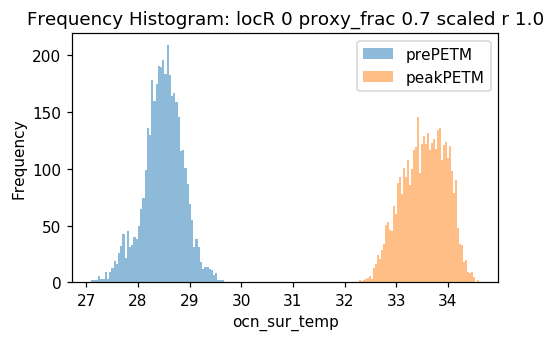

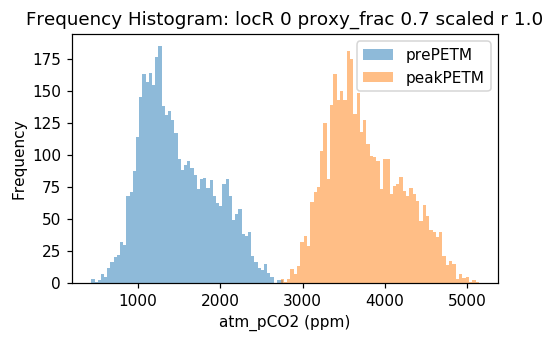

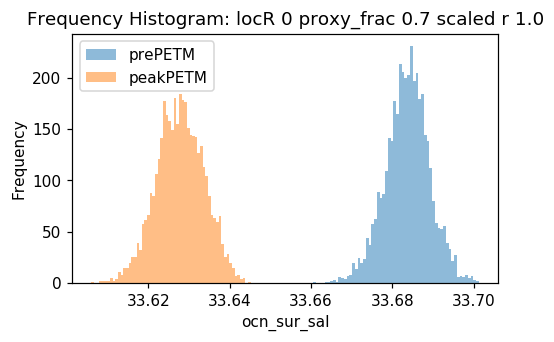

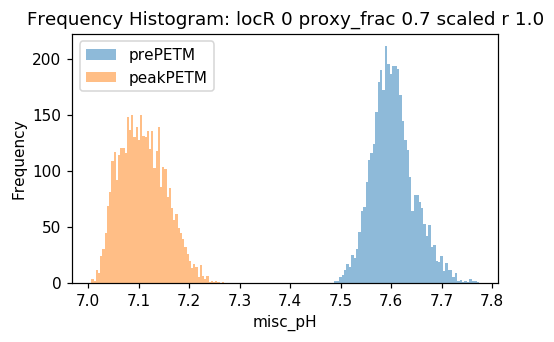

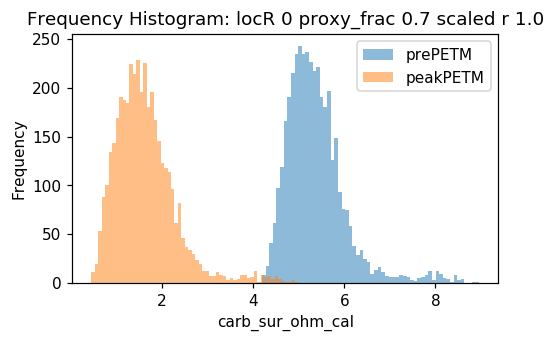

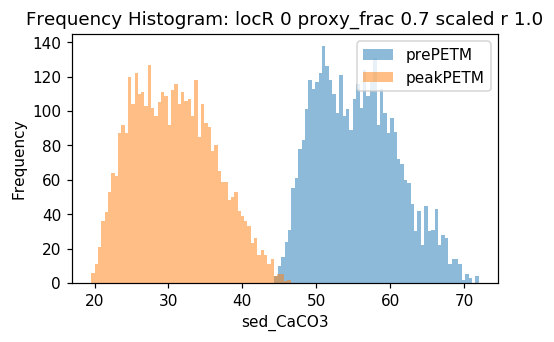

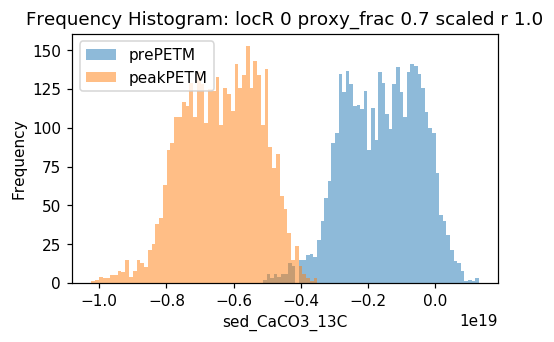

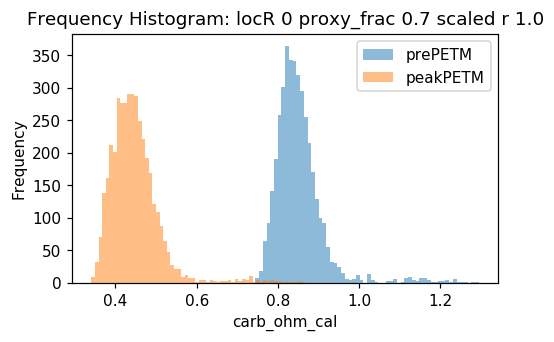

In [2]:
# Calculate mean and std of each variable for each time slice
# plot the ensemble values
#####################    User defined start   #####################
label_all = ('prePETM', 'peakPETM', 'PETM','postPETM')
label_all_len = len(label_all)
warmcomp = [0,1]  # ID for petm warming
print('DA - Summary of global mean and standard deviation')
print('')
#####################    User defined end     #####################

for locRadi in range(locRadn):
    locRad = local_rad_list[locRadi]
    if locRad is None:
        locRadv = 0 # for filename only
    else:
        locRadv = locRad
        
    for proxy_fraci in range(proxy_fracn):
        proxy_frac = proxy_frac_list[proxy_fraci]
        
        for Rscalei in range(Rscalen):
            Rscale = Rscale_list[Rscalei]
            
            # 2d variables
            for Xa2d_vari in range(prior_variable_len):
                print(prior_variable_dict[Xa2d_vari])
                
                sst_std_mc = np.std(Xa2d_mean_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,:],axis=0)
                print('  _locR '+str(locRadv)+' proxy_frac '+str(proxy_frac)+' scaled r '+str(Rscale))

                for reconi in range(recon_period_len):
                    
                    meani = np.nanmean(Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi])
                    stdi = np.std(Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi])
                    if recon_period_len>2:
                        warmpeak = Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,1]-Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,0]
                        warmbody = Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,2]-Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,0]
                        warmpeakmean = np.nanmean(warmpeak)
                        warmpeakstd = np.std(warmpeak)
                        warmbodymean = np.nanmean(warmbody)
                        warmbodystd = np.std(warmbody)
                    
                    if prior_variable_dict[Xa2d_vari] in ['atm_pCO2']:
                        print('    {:.3f} ± {:.3f}: {}'.format(meani*1e6, stdi*1e6, label_all[reconi]))
                    else:
                        print('    {:.3f} ± {:.3f}: {}'.format(meani, stdi, label_all[reconi]))
                if recon_period_len>2:
                    print('    warming peak: {:.6f} ± {:.6f}'.format(warmpeakmean,warmpeakstd))
                    print('    warming body: {:.6f} ± {:.6f}'.format(warmbodymean,warmbodystd))

                plt.rcParams.update({'figure.figsize':(5,3), 'figure.dpi':110})
                fig = plt.figure()
                for reconi in range(recon_period_len):
                    kwargs = dict(alpha=0.5, bins=60)
                    if prior_variable_dict[Xa2d_vari] in ['atm_pCO2']:
                        plt.hist(Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi]*1e6, **kwargs, label = label_all[reconi])
                        plt.gca().set(xlabel = prior_variable_dict[Xa2d_vari]+ ' (ppm)');
                    else:
                        plt.hist(Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi], **kwargs, label = label_all[reconi])
                        plt.gca().set(xlabel = prior_variable_dict[Xa2d_vari]);
                    plt.gca().set(title='Frequency Histogram: locR '+str(locRadv)+' proxy_frac '+str(proxy_frac)+' scaled r '+str(Rscale), ylabel='Frequency');
                    
                    plt.legend();

In [13]:
### Purpose of this block
# Prepare data for verification
### Steps
# 1. Prepare matrix for data saving: proxy, prior, posterior; std or not
# 2. calculate and save each Monte Carlo runs

#####################    User defined start   #####################
verbose = True
Typelist = ['d18O','TEX86','MgCa','caco3']
#Typelist = ['caco3']
#Typelist = ['d18O','TEX86','MgCa']
print('DA - Read proxy, prior, and posterior, standardize')
print('')
#####################    User defined end     #####################
locRad = local_rad_list[0]
if locRad is None:
    locRadv = 0 # for filename only
else:
    locRadv = locRad
proxy_frac = proxy_frac_list[0]
Rscale = Rscale_list[0]
filename_short = '_loc_', str(locRadv),'_proxy_frac_', str(proxy_frac),'_Rscale_',str(Rscale),'_MC_0.hdf5'
hdf5name = MC_dir + ''.join(filename_short)
print('Read first hdf5 file {} to get the number of withold datasets.'.format(hdf5name))
sites_eval = pandas.read_hdf(hdf5name, 'sites_eval')
sites_withhold_len  = len(sites_eval)
print(' Site withhold length ： {}'.format(sites_withhold_len))

# Prepare empty matrix for saving the data of proxy, prior, and posterior
ob_stat = np.full((locRadn,proxy_fracn,Rscalen,MCn, recon_period_len*2, sites_withhold_len), np.nan)
xb_stat = np.full((locRadn,proxy_fracn,Rscalen,MCn, 2, sites_withhold_len), np.nan)   # save full prior for withhold data
xa_stat = np.full((locRadn,proxy_fracn,Rscalen,MCn, recon_period_len*2, sites_withhold_len), np.nan)

# Prepare empty matrix for saving the data of proxy, prior, and posterior; standardized
ob_std = np.copy(ob_stat)
xb_std = np.copy(xb_stat)
xa_std = np.copy(xa_stat)

# calculate each Monte Carlo runs
for locRadi in range(locRadn):
    locRad = local_rad_list[locRadi]
    if locRad is None:
        locRadv = 0 # for filename only
    else:
        locRadv = locRad
        
    for proxy_fraci in range(proxy_fracn):
        proxy_frac = proxy_frac_list[proxy_fraci]
        
        for Rscalei in range(Rscalen):
            Rscale = Rscale_list[Rscalei]
            
            for MCi in range(MCn):
            #for MCi in range(1):
                # NetCDF file name
                filename_short = '_loc_', str(locRadv),'_proxy_frac_', str(proxy_frac),'_Rscale_',str(Rscale),'_MC_' + str(MCi)
                nc_filename = MC_dir + ''.join(filename_short) + '.nc'
                hdf5name    = MC_dir + ''.join(filename_short) + '.hdf5'
                print('    {}'.format(nc_filename))
                
                ### Read Proxy ###
                proxies=pandas.read_hdf(hdf5name, 'proxies')
                prior_variable_dict = pandas.read_hdf(hdf5name, 'prior_variable_dict')
                
                if proxy_frac <= 1.0:
                    sites_eval = pandas.read_hdf(hdf5name, 'sites_eval')
                    sites_withhold_len  = len(sites_eval)                    
                    if verbose:
                        print('Site withhold:       {}'.format(sites_eval['Site'].values))
                        print('Proxy        :       {}'.format(sites_eval['Proxy'].values))
                
                proxy_psm_type_dict_df = pandas.read_hdf(hdf5name, 'proxy_psm_type_dict_df')
                proxy_psm_type_dict_list = proxy_psm_type_dict_df[0].values.tolist()

                for j in range(sites_withhold_len):
                    data_psm_type = sites_eval['Proxy'][j]
                    for key, value in proxy_assim2.items():
                        if data_psm_type in value:
                            #print(proxy_psm_type[key])
                            key0 = key
                            psm_required_variable_key = list(yml_dict['psm'][proxy_psm_type[key]]['psm_required_variables'].keys())[0]
                            xb_key = psm_required_variable_key+'_Xb_full'
                            xa_key = psm_required_variable_key+'_Xa_full'
                            #print('xa_key is {}'.format(xa_key))
                            Xb_full_field0 = Dataset(nc_filename).variables[xb_key] #
                            Xb_full_field0 = Xb_full_field0[:,:,:,0].reshape(dum_imax*dum_jmax, nens)                        
                            Xa_full_field0 = Dataset(nc_filename).variables[xa_key]
                        
                    if proxy_psm_type[key0] in ['bayesreg_tex86', 'bayesreg_d18o_pooled', 'cgenie_caco3']:
                        Ye = DeepDA_psm.cal_ye_cgenie(yml_dict,sites_eval,j,Xb_full_field0,proxy_assim2,proxy_psm_type,dum_lon_offset,dum_imax,dum_jmax)
                        #Ye = DeepDA_psm.cal_ye_cgenie(yml_dict,sites_eval,j,Xb0,proxy_assim2,proxy_psm_type,dum_lon_offset,dum_imax,dum_jmax)
                        xb_stat[locRadi][proxy_fraci][Rscalei][MCi][0][j] = np.mean(Ye)
                        xb_stat[locRadi][proxy_fraci][Rscalei][MCi][1][j] = np.var(Ye)
                        #print('Prior Ye is {:.6f}'.format(np.mean(Ye)))
                        for reconi in range(recon_period_len):
                            Xa_reconi = Xa_full_field0[:,:,:,0,reconi].reshape((dum_imax*dum_jmax,nens))
                            Ye = DeepDA_psm.cal_ye_cgenie(yml_dict,sites_eval,j,Xa_reconi,proxy_assim2,proxy_psm_type,dum_lon_offset,dum_imax,dum_jmax)
                            xa_stat[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][j]   = np.mean(Ye)
                            xa_stat[locRadi][proxy_fraci][Rscalei][MCi][2*reconi+1][j] = np.var(Ye)
                            #print('Analysis Ye is {:.6f}'.format(np.mean(Ye)))

                            #ob_stat[j][reconi*2]   = sites_eval[data_period_id[reconi]][j]
                            ob_stat[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][j] = sites_eval[data_period_id[reconi]][j]
                            if ~np.isnan(sites_eval[data_period_id[reconi]][j]):
                                if proxy_psm_type[key0] in ['bayesreg_tex86']:
                                    if proxy_err_eval in ['proxy_err_psm']:
                                        ob_stat[locRadi][proxy_fraci][Rscalei][MCi][reconi*2+1][j] = DeepDA_psm.obs_estimate_r_fixed_tex86(31) + sites_eval[data_period_idstd[reconi]][j] ** 2
                                    else:
                                        ob_stat[locRadi][proxy_fraci][Rscalei][MCi][reconi*2+1][j] = DeepDA_psm.obs_estimate_r_fixed_tex86(31)                                        
                                if proxy_psm_type[key0] in ['bayesreg_d18o_pooled']:
                                    if proxy_err_eval in ['proxy_err_psm']:
                                        ob_stat[locRadi][proxy_fraci][Rscalei][MCi][reconi*2+1][j] = DeepDA_psm.obs_estimate_r_fixed_d18o(15) + sites_eval[data_period_idstd[reconi]][j] ** 2
                                    else:
                                        ob_stat[locRadi][proxy_fraci][Rscalei][MCi][reconi*2+1][j] = DeepDA_psm.obs_estimate_r_fixed_d18o(15)                                        
                                if proxy_psm_type[key0] in ['cgenie_caco3','cgenie_caco3_13c']:
                                    psm_error = yml_dict['psm'][proxy_psm_type[key0]]['psm_error']
                                    if proxy_err_eval in ['proxy_err_psm']:
                                        ob_stat[locRadi][proxy_fraci][Rscalei][MCi][reconi*2+1][j] = psm_error + sites_eval[data_period_idstd[reconi]][j] ** 2
                                    else:
                                        ob_stat[locRadi][proxy_fraci][Rscalei][MCi][reconi*2+1][j] = psm_error
                                        
                    elif proxy_psm_type[key0] in ['bayesreg_mgca_pooled_bcp', 'bayesreg_mgca_pooled_red']:
                        spp = 'all'
                        cleaningr = np.tile(np.array([1]),nens)
                        cleaningb = np.tile(np.array([0]),nens)
                        if proxy_psm_type[key0] in ['bayesreg_mgca_pooled_red']:
                            clearning_one = cleaningr
                            proxy_explain = 'reductive'
                        elif proxy_psm_type[key0] in ['bayesreg_mgca_pooled_bcp']:
                            clearning_one = cleaningb
                            proxy_explain = 'barker'

                        #print('    Mg/Ca proxy found. Load salinity, pH and omega')
                        with h5py.File(hdf5name, 'r') as f:
                            Xb_sal = f.get('Xb_sal')
                            Xb_omega = f.get('Xb_omega')
                            Xb_ph = f.get('Xb_ph')
                            Ye = DeepDA_psm.cal_ye_cgenie_mgca(yml_dict,sites_eval,j,Xb_full_field0,proxy_psm_type[key0],dum_lon_offset,dum_imax,dum_jmax,Xb_sal,Xb_ph,Xb_omega,geologic_age)
                            #Ye = DeepDA_psm.cal_ye_cgenie_mgca(yml_dict,sites_eval,j,Xb0,proxy_psm_type[key0],dum_lon_offset,dum_imax,dum_jmax,Xb_sal,Xb_ph,Xb_omega,geologic_age)
                            xb_stat[locRadi][proxy_fraci][Rscalei][MCi][0][j] = np.mean(Ye)
                            xb_stat[locRadi][proxy_fraci][Rscalei][MCi][1][j] = np.var(Ye)
                        Xa_sal_full = Dataset(nc_filename).variables['ocn_sur_sal_Xa_full']
                        Xa_ph_full  = Dataset(nc_filename).variables['misc_pH_Xa_full']
                        Xa_omega_full = Dataset(nc_filename).variables['carb_sur_ohm_cal_Xa_full']

                        for reconi in range(recon_period_len):
                            Xa_reconi = Xa_full_field0[:,:,:,0,reconi].reshape((dum_imax*dum_jmax,nens))
                            Xb_sal   =   Xa_sal_full[:,:,:,0,reconi].reshape((dum_imax*dum_jmax,nens))
                            Xb_ph    =    Xa_ph_full[:,:,:,0,reconi].reshape((dum_imax*dum_jmax,nens))
                            Xb_omega = Xa_omega_full[:,:,:,0,reconi].reshape((dum_imax*dum_jmax,nens))

                            Ye = DeepDA_psm.cal_ye_cgenie_mgca(yml_dict,sites_eval,j,Xa_reconi,proxy_psm_type[key0],dum_lon_offset,dum_imax,dum_jmax,Xb_sal,Xb_ph,Xb_omega,geologic_age)
                            xa_stat[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][j]   = np.mean(Ye)
                            xa_stat[locRadi][proxy_fraci][Rscalei][MCi][2*reconi+1][j] = np.var(Ye)

                            ob_stat[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][j] = sites_eval[data_period_id[reconi]][j]
                            if ~np.isnan(sites_eval[data_period_id[reconi]][j]):
                                ob_err0 = DeepDA_psm.obs_estimate_r_fixed_mgca_pooled((15, 16), clearning_one[0], np.nanmean(Xb_sal), np.nanmean(Xb_ph), np.nanmean(Xb_omega), spp, geologic_age)
                                if proxy_err_eval in ['proxy_err_psm']:
                                    ob_stat[locRadi][proxy_fraci][Rscalei][MCi][reconi*2+1][j] = ob_err0 + sites_eval[data_period_idstd[reconi]][j] ** 2
                                else:
                                    ob_stat[locRadi][proxy_fraci][Rscalei][MCi][reconi*2+1][j] = ob_err0
                
                # save proxy, prior, and posterior data and then standardized
                
                xb_std[locRadi][proxy_fraci][Rscalei][MCi][1][:] = np.copy(xb_stat[locRadi][proxy_fraci][Rscalei][MCi][1][:])
                # for each time slices
                for reconi in range(recon_period_len):
                    ob_std[locRadi][proxy_fraci][Rscalei][MCi][2*reconi+1][:] = np.copy(ob_stat[locRadi][proxy_fraci][Rscalei][MCi][reconi*2+1][:])
                    xa_std[locRadi][proxy_fraci][Rscalei][MCi][2*reconi+1][:] = np.copy(xa_stat[locRadi][proxy_fraci][Rscalei][MCi][reconi*2+1][:])
                    # for each proxy type
                    id1 = 0
                    for ki in range(len(Typelist)):
                        
                        sites_s = sites_eval[sites_eval.Type == Typelist[ki]]
                        
                        if reconi + MCi == 0:
                            print('# withhold datasets of {}: {}'.format(Typelist[ki], len(sites_s)))
                        id2 = id1 + len(sites_s)
                        
                        # select observations which type is the same
                        ob_s = ob_stat[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][sites_eval.Type == Typelist[ki]]
                        ct_nonnan0 = sum(~np.isnan(ob_s)) # count non nan values
                        #print('  Count non nan values {}'.format(ct_nonnan0 ))
                        if ct_nonnan0 >= 1:
                            print('observation withhold {}'.format(ob_s))
                            ob_s_std = stats.zscore(ob_s, nan_policy = 'omit')
                            ob_std[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][id1:id2] = np.copy(ob_s_std)
                            
                        # select posterior/analysis which type is the same
                        xa_s = xa_stat[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][sites_eval.Type == Typelist[ki]]
                        ct_nonnan1 = sum(~np.isnan(xa_s)) # count non nan values
                        if ct_nonnan1 >= 1:
                            xa_s_std = stats.zscore(xa_s, nan_policy = 'omit')
                            xa_std[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][id1:id2] = np.copy(xa_s_std)
                            
                        if reconi == 0:
                            # select prior/model which type is the same
                            xb_s = xb_stat[locRadi][proxy_fraci][Rscalei][MCi][0][sites_eval.Type == Typelist[ki]]
                            ct_nonnan2 = sum(~np.isnan(xb_s)) # count non nan values
                            if ct_nonnan2 >= 1:
                                xb_s_std = stats.zscore(xb_s, nan_policy = 'omit')
                                xb_std[locRadi][proxy_fraci][Rscalei][MCi][0][id1:id2] = np.copy(xb_s_std)
                                
                        id1 = id2

print('Done.')

DA - Read proxy, prior, and posterior, standardize

Read first hdf5 file /mnt/d/DeepDA/wrk/petmproxy3slices_v0.0.12.csv_petm9_v12_20200427_all_glassy_pre_peak_noCaCO3/_loc_0_proxy_frac_0.7_Rscale_1.0_MC_0.hdf5 to get the number of withold datasets.
 Site withhold length ： 13
    /mnt/d/DeepDA/wrk/petmproxy3slices_v0.0.12.csv_petm9_v12_20200427_all_glassy_pre_peak_noCaCO3/_loc_0_proxy_frac_0.7_Rscale_1.0_MC_0.nc
Site withhold:       ['401' '401' 'tumey' '527' '865' 'WL' '1172' '1209' 'BR' 'fur' 'lodo' 'sq'
 'sq']
Proxy        :       ['d18o_m.subb' 'mgca_m.subb:barker' 'd18o_acarinina' 'mgca_m.subb:barker'
 'd18o_morozovella' 'd18o_morozovella' 'tex86' 'mgca_acarinina:reductive'
 'tex86' 'tex86' 'd18o_morozovella' 'd18o_acarinina' 'tex86']
# withhold datasets of d18O: 6
observation withhold [-1.655826       nan -3.258          nan       nan -3.397277]
# withhold datasets of TEX86: 4
observation withhold [0.6295  0.762   0.53    0.84429]
# withhold datasets of MgCa: 3
observation withhol

/home/mul450/miniconda3/envs/lmr_py3/lib/python3.6/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


observation withhold [-2.32698        nan -3.437143]
observation withhold [    nan 0.698   0.6555  0.762   0.72619]
observation withhold [3.54245 4.33167 3.89999 4.64567 4.20453]
observation withhold [-3.57 -3.21 -3.75]
observation withhold [0.7   0.933 0.82  0.92  0.889]
observation withhold [4.240912      nan 4.710681      nan      nan]
    /mnt/d/DeepDA/wrk/petmproxy3slices_v0.0.12.csv_petm9_v12_20200427_all_glassy_pre_peak_noCaCO3/_loc_0_proxy_frac_0.7_Rscale_1.0_MC_5.nc
Site withhold:       ['tanzania' 'tumey' 'waipara' '690' '865' 'WL' 'WL' '865' '1172' 'fur'
 'sq' 'sq' 'GreatBelt']
Proxy        :       ['d18o_a.soldadoensis' 'd18o_morozovella' 'tex86' 'd18o_acarinina'
 'd18o_morozovella' 'd18o_morozovella' 'tex86' 'mgca_acarinina:barker'
 'tex86' 'tex86' 'd18o_morozovella' 'mgca_acarinina:reductive' 'tex86']
observation withhold [-3.132308       nan       nan -3.258          nan -3.773568]
observation withhold [0.5373  0.698   0.6295  0.53    0.53143]
observation withhold [4.057

In [14]:
# show one MC results

validthisblock = 1

if validthisblock> 0:
    print(MCi)
    print('Done. Show first time-slice data of')
    print(' xb_std ')
    print(xb_std[locRadi,proxy_fraci,Rscalei,MCi,0,:])
    print(' and ')
    print('  ')
    print(' xa_std ')
    print(xa_std[locRadi,proxy_fraci,Rscalei,MCi,0,:])
    print(' ob_std ')
    print(ob_std[locRadi,proxy_fraci,Rscalei,MCi,0,:])
    print('  ')
    if validthisblock>1:
        print('2 nd slice peakPETM')
        print(' xa_std ')
        print(xa_std[locRadi,proxy_fraci,Rscalei,MCi,2,:])
        print(' ob_std ')
        print(ob_std[locRadi,proxy_fraci,Rscalei,MCi,2,:])
        print('  ')
        print('  ')

    print('. Show first time-slice data of')
    print(' xb_stat ')
    print(xb_stat[locRadi,proxy_fraci,Rscalei,MCi,0,:])
    print(' and ')
    print('  ')
    print(' xa_stat ')
    print(xa_stat[locRadi,proxy_fraci,Rscalei,MCi,0,:])
    print(' ob_stat ')
    print(ob_stat[locRadi,proxy_fraci,Rscalei,MCi,0,:])
    print('  ')
    if validthisblock>1:
        print('2 nd slice peakPETM')
        print(' xa_stat ')
        print(xa_stat[locRadi,proxy_fraci,Rscalei,MCi,2,:])
        print(' ob_stat ')
        print(ob_stat[locRadi,proxy_fraci,Rscalei,MCi,2,:])
        print('  ')

19
Done. Show first time-slice data of
 xb_std 
[ 0.683339 -1.728311  0.52084   0.524131 -1.222072  0.521154 -0.257707
 -0.684527  1.643152 -1.517247  0.897643  0.901513 -0.281909]
 and 
  
 xa_std 
[ 0.684351 -1.728239  0.520898  0.52299  -1.20149   0.482932 -0.24866
 -0.698257  1.665474 -1.515975  0.899462  0.901023 -0.28451 ]
 ob_std 
[      nan       nan       nan       nan -0.402699 -1.034573       nan
 -0.212658  1.64993  -0.889787       nan  1.396844 -0.507057]
  
. Show first time-slice data of
 xb_stat 
[ 0.391028 -2.685562  2.954206  0.655227  0.537185 -3.499426  4.9333
  4.936472  0.472497  3.966612  0.825274 -2.740401 -2.739291]
 and 
  
 xa_stat 
[ 0.355328 -1.928522  1.948787  0.596712  0.491872 -2.740739  3.164686
  3.165472  0.427443  2.56869   0.766174 -1.98355  -1.982845]
 ob_stat 
[0.608182      nan 3.437604 0.5373        nan      nan      nan 4.33167
 0.6295   3.58725  0.83844       nan      nan]
  



NSE & RMSE calculation ... 
    raw data used 
    each time slice calculated 
      NSE & RMSE calculation: Done!
  prePETM
    mean of CE   [0.906167 0.937451]
    mean of RMSE [0.798179 0.613704]
  peakPETM
    mean of CE   [0.955766 0.949216]
    mean of RMSE [0.640367 0.681886]
  NSE & RMSE calculation ... 
    raw data used 
    all time slice together 
      NSE & RMSE calculation: Done!
      mean of CE   [0.941087 0.95263 ]
      mean of RMSE [0.730724 0.654756]

NSE & RMSE calculation ... 
    standardized data used 
    each time slice calculated 
      NSE & RMSE calculation: Done!
  prePETM
    mean of CE   [0.322476 0.327139]
    mean of RMSE [0.793459 0.791075]
  peakPETM
    mean of CE   [0.401499 0.399124]
    mean of RMSE [0.751022 0.754655]
  NSE & RMSE calculation ... 
    standardized data used 
    all time slice together 
      NSE & RMSE calculation: Done!
      mean of CE   [0.352556 0.353395]
      mean of RMSE [0.79116  0.790914]


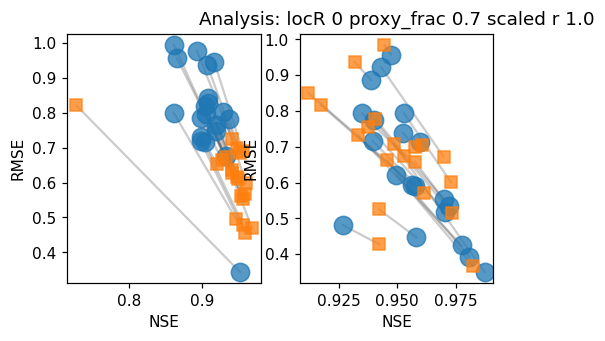

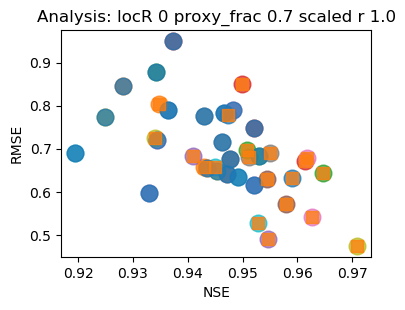

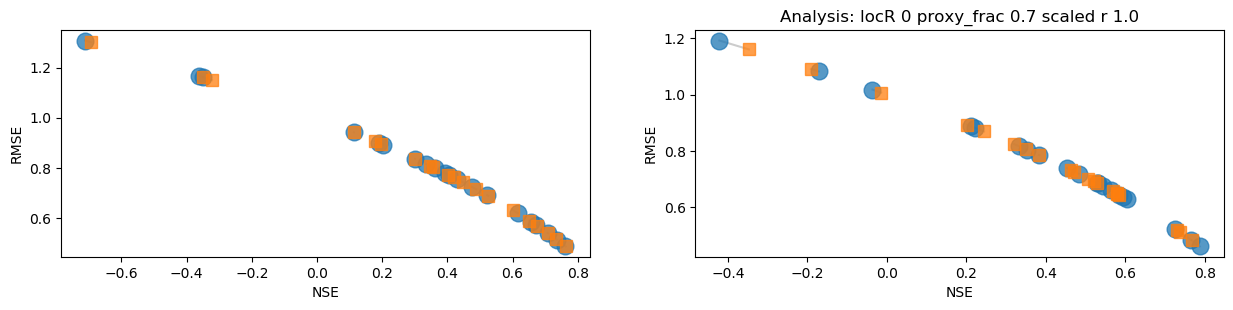

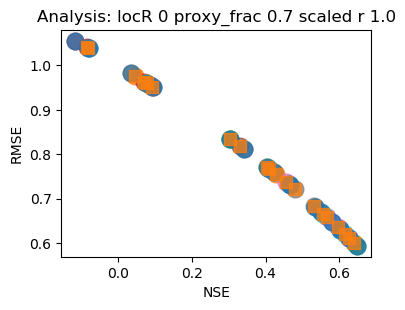

In [15]:
# validataion
# calculate CE and RMSE for each time slices
# plot CE and RMSE

stdtf = [False,True] # True: standardize; False: use raw analysis data
cetf = [False,True] # True: calculate ce in all; False: calculate ce for each time slice
verbose = False

for stdi in range(2):
    for allcei in range(2):
        allce = cetf[allcei]
        AnalysisStd = stdtf[stdi]
        if allcei == 0:
            print('')
            print('NSE & RMSE calculation ... ')
        else:            
            print('  NSE & RMSE calculation ... ')
        if AnalysisStd:
            ob_stat_select = np.copy(ob_std)
            xb_stat_select = np.copy(xb_std)
            xa_stat_select = np.copy(xa_std)
            print('    standardized data used ')
        else:
            ob_stat_select = np.copy(ob_stat)
            xb_stat_select = np.copy(xb_stat)
            xa_stat_select = np.copy(xa_stat)
            print('    raw data used ')

        # calculate NSE & RMSE
        if allce:
            CE_stat = np.full((locRadn,proxy_fracn,Rscalen,MCn,2), np.nan)
            RMSE_stat=np.full((locRadn,proxy_fracn,Rscalen,MCn,2), np.nan)
            print('    all time slice together ')
            CE_all = np.full((locRadn,proxy_fracn,Rscalen,2), np.nan)
            RMSE_all=np.full((locRadn,proxy_fracn,Rscalen,2), np.nan)
        else:
            CE_stat = np.full((locRadn,proxy_fracn,Rscalen,MCn,2,recon_period_len), np.nan)
            RMSE_stat=np.full((locRadn,proxy_fracn,Rscalen,MCn,2,recon_period_len), np.nan)
            print('    each time slice calculated ')
            
        
        
        reconlist = np.arange(0,2*recon_period_len,2)
        # calculate each Monte Carlo runs
        for locRadi in range(locRadn):
            locRad = local_rad_list[locRadi]
            if locRad is None:
                locRadv = 0 # for filename only
            else:
                locRadv = locRad

            for proxy_fraci in range(proxy_fracn):
                proxy_frac = proxy_frac_list[proxy_fraci]

                for Rscalei in range(Rscalen):
                    Rscale = Rscale_list[Rscalei]
                    
                    if allce:
                        dataall     = ob_stat_select[locRadi,proxy_fraci,Rscalei,:,reconlist,:].flatten('F')
                        modelall    = np.matlib.repmat(xb_stat_select[locRadi,proxy_fraci,Rscalei,:,0,:],reconi+1,1).flatten('F')
                        analysisall = xa_stat_select[locRadi,proxy_fraci,Rscalei,:,reconlist,:].flatten('F')
                        CE_all[locRadi,proxy_fraci,Rscalei,0] = DeepDA_psm.CE_NS70(dataall, modelall,1)
                        CE_all[locRadi,proxy_fraci,Rscalei,1] = DeepDA_psm.CE_NS70(dataall, analysisall,1)
                        RMSE_all[locRadi,proxy_fraci,Rscalei,0] = np.sqrt(np.nanmean((modelall - dataall) ** 2))
                        RMSE_all[locRadi,proxy_fraci,Rscalei,1] = np.sqrt(np.nanmean((analysisall - dataall) ** 2))
                        if verbose:
                            filename_short = '      _loc_', str(locRadv),'_proxy_frac_', str(proxy_frac),'_Rscale_',str(Rscale)
                            print('>>{}'.format(filename_short))
                            print('>>  all data     {}'.format(dataall))
                            print('>>  all model    {}'.format(modelall))
                            print('>>  all analysis {}'.format(analysisall))
                            print('>>  Prior    CE: obs vs. xb {}'.format(CE_all[locRadi,proxy_fraci,Rscalei,0]))
                            print('>>  Analysis CE: obs vs. xa {}'.format(CE_all[locRadi,proxy_fraci,Rscalei,1]))
                            print('>>  Prior    RMSE: obs vs. xb {}'.format(RMSE_all[locRadi,proxy_fraci,Rscalei,0]))
                            print('>>  Analysis RMSE: obs vs. xa {}'.format(RMSE_all[locRadi,proxy_fraci,Rscalei,1]))

                    for MCi in range(MCn):
                        filename_short = '      _loc_', str(locRadv),'_proxy_frac_', str(proxy_frac),'_Rscale_',str(Rscale),'_MC_' + str(MCi)
                        data     = ob_stat_select[locRadi,proxy_fraci,Rscalei,MCi,reconlist,:]
                        model    = np.matlib.repmat(xb_stat_select[locRadi,proxy_fraci,Rscalei,MCi,0,:],reconi+1,1)
                        analysis = xa_stat_select[locRadi,proxy_fraci,Rscalei,MCi,reconlist,:]
                        if verbose:
                            print('>>{}'.format(filename_short))
                            print('>>  data     {}'.format(data))
                            print('>>  model    {}'.format(model))
                            print('>>  analysis {}'.format(analysis))
                        if allce:
                            data     = data.flatten('F')
                            model    = model.flatten('F')
                            analysis = analysis.flatten('F')                                           
                            CE_stat[locRadi,proxy_fraci,Rscalei,MCi,0] = DeepDA_psm.CE_NS70(data, model,1)
                            CE_stat[locRadi,proxy_fraci,Rscalei,MCi,1] = DeepDA_psm.CE_NS70(data, analysis,1)                            
                            RMSE_stat[locRadi,proxy_fraci,Rscalei,MCi,0] = np.sqrt(np.nanmean((model - data) ** 2))
                            RMSE_stat[locRadi,proxy_fraci,Rscalei,MCi,1] = np.sqrt(np.nanmean((analysis - data) ** 2))
                            if verbose:
                                print('>>  Prior    CE: obs vs. xb {}'.format(CE_stat[locRadi,proxy_fraci,Rscalei,MCi,0]))
                                print('>>  Analysis CE: obs vs. xa {}'.format(CE_stat[locRadi,proxy_fraci,Rscalei,MCi,1]))
                                print('>>  Prior    RMSE: obs vs. xb {}'.format(RMSE_stat[locRadi,proxy_fraci,Rscalei,MCi,0]))
                                print('>>  Analysis RMSE: obs vs. xa {}'.format(RMSE_stat[locRadi,proxy_fraci,Rscalei,MCi,1]))
                        else:
                            CE_stat[locRadi,proxy_fraci,Rscalei,MCi,0,:] = DeepDA_psm.CE_NS70(data, model, 0)
                            CE_stat[locRadi,proxy_fraci,Rscalei,MCi,1,:] = DeepDA_psm.CE_NS70(data, analysis, 0)
                            RMSE_stat[locRadi,proxy_fraci,Rscalei,MCi,0,:] = np.sqrt(np.nanmean((model - data) ** 2, axis=1))
                            RMSE_stat[locRadi,proxy_fraci,Rscalei,MCi,1,:] = np.sqrt(np.nanmean((analysis - data) ** 2, axis=1))
                            if verbose:
                                print('>>  Prior    CE: obs vs. xb {}'.format(CE_stat[locRadi,proxy_fraci,Rscalei,MCi,0,:]))
                                print('>>  Analysis CE: obs vs. xa {}'.format(CE_stat[locRadi,proxy_fraci,Rscalei,MCi,1,:]))
                                print('>>  Prior    RMSE: obs vs. xb {}'.format(RMSE_stat[locRadi,proxy_fraci,Rscalei,MCi,0,:]))
                                print('>>  Analysis RMSE: obs vs. xa {}'.format(RMSE_stat[locRadi,proxy_fraci,Rscalei,MCi,1,:]))
        print('      NSE & RMSE calculation: Done!')
        
        # PLot
        # calculate each Monte Carlo runs
        for locRadi in range(locRadn):
            locRad = local_rad_list[locRadi]
            if locRad is None:
                locRadv = 0 # for filename only
            else:
                locRadv = locRad

            for proxy_fraci in range(proxy_fracn):
                proxy_frac = proxy_frac_list[proxy_fraci]

                for Rscalei in range(Rscalen):
                    Rscale = Rscale_list[Rscalei]
                    
                    fig = plt.figure()                    
                    if allce:
                        kwargs = dict(alpha=0.75, marker='o', markersize=12, linestyle='',label = 'Prior')
                        for MCi in range(MCn):
                            plt.plot(CE_stat[locRadi,proxy_fraci,Rscalei,MCi,:],RMSE_stat[locRadi,proxy_fraci,Rscalei,MCi,:], **kwargs)
                            
                        kwargs = dict(alpha=0.75, marker='o', markersize=12, linestyle='',label = 'Prior')
                        plt.plot(CE_stat[locRadi,proxy_fraci,Rscalei,:,0],RMSE_stat[locRadi,proxy_fraci,Rscalei,:,0], **kwargs)
                        plt.gca().set(ylabel='RMSE', xlabel = 'NSE');
                        #plt.legend();

                        kwargs = dict(alpha=0.75, marker='s', markersize=8, linestyle='',label = 'Analysis')
                        plt.plot(CE_stat[locRadi,proxy_fraci,Rscalei,:,1],RMSE_stat[locRadi,proxy_fraci,Rscalei,:,1], **kwargs)
                        #plt.legend();
                        
                        plt.gca().set(title='Analysis: locR '+str(locRadv)+' proxy_frac '+str(proxy_frac)+' scaled r '+str(Rscale), ylabel='RMSE', xlabel = 'NSE');

                        CEmean = np.mean(CE_stat[locRadi,proxy_fraci,Rscalei,:,:],axis = 0)
                        RMSEmean=np.mean(RMSE_stat[locRadi,proxy_fraci,Rscalei,:,:],axis = 0)
                        print('      mean of CE   {}'.format(CEmean))
                        print('      mean of RMSE {}'.format(RMSEmean))
                        plt.rcParams.update({'figure.figsize':(15,3), 'figure.dpi':100})
                        
                    else:
                        
                        for reconi in range(recon_period_len):

                            plt.subplot(1, recon_period_len, reconi+1)
                            kwargs = dict(alpha=0.2, linestyle='-', color = 'k')
                            
                            for MCi in range(MCn):
                                plt.plot(CE_stat[locRadi,proxy_fraci,Rscalei,MCi,:,reconi],RMSE_stat[locRadi,proxy_fraci,Rscalei,MCi,:,reconi], **kwargs)

                            kwargs = dict(alpha=0.75, marker='o', markersize=12, linestyle='',label = 'Prior '+label_all[reconi])
                            plt.plot(CE_stat[locRadi,proxy_fraci,Rscalei,:,0,reconi],RMSE_stat[locRadi,proxy_fraci,Rscalei,:,0,reconi], **kwargs)
                            plt.gca().set(ylabel='RMSE', xlabel = 'NSE');
                            #plt.legend();

                            kwargs = dict(alpha=0.75, marker='s', markersize=8, linestyle='',label = 'Analysis '+label_all[reconi])
                            plt.plot(CE_stat[locRadi,proxy_fraci,Rscalei,:,1,reconi],RMSE_stat[locRadi,proxy_fraci,Rscalei,:,1,reconi], **kwargs)
                            #plt.legend();
                            if reconi == 1:
                                plt.gca().set(title='Analysis: locR '+str(locRadv)+' proxy_frac '+str(proxy_frac)+' scaled r '+str(Rscale), ylabel='RMSE', xlabel = 'NSE');

                            print('  {}'.format(label_all[reconi]))
                            CEmean = np.mean(CE_stat[locRadi,proxy_fraci,Rscalei,:,:,reconi],axis = 0)
                            RMSEmean=np.mean(RMSE_stat[locRadi,proxy_fraci,Rscalei,:,:,reconi],axis = 0)
                            print('    mean of CE   {}'.format(CEmean))
                            print('    mean of RMSE {}'.format(RMSEmean))
                            plt.rcParams.update({'figure.figsize':(4,3), 'figure.dpi':100})

standardized data used 
  each time slice calculated 


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


raw data used ... 
  each time slice calculated 


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


standardized data used 
  all time slice used 
raw data used ... 
  all time slice used 


'/mnt/d/DeepDA/wrk/petmproxy3slices_v0.0.12.csv_petm9_v12_20200427_all_glassy_pre_peak_noCaCO3/DeepDA_verify.html'

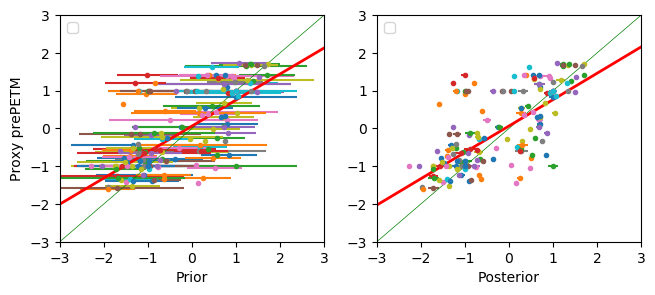

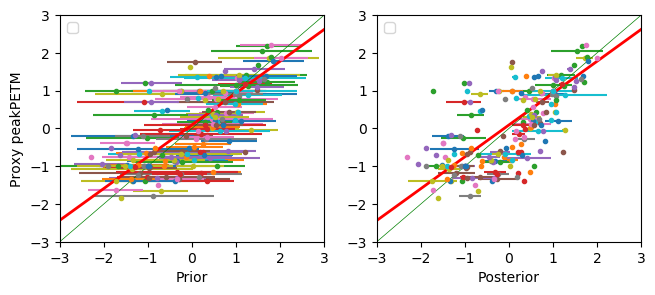

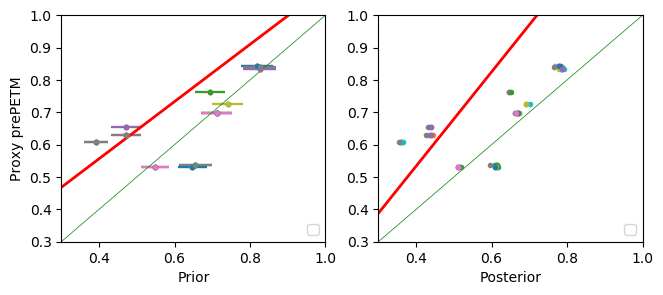

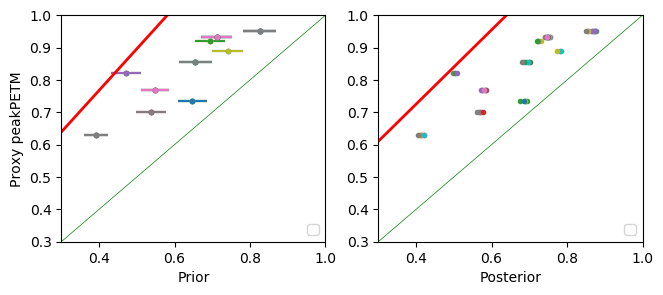

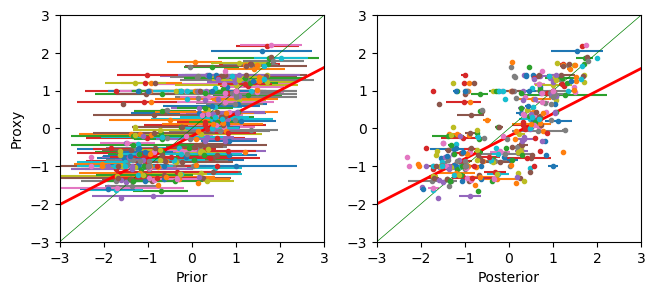

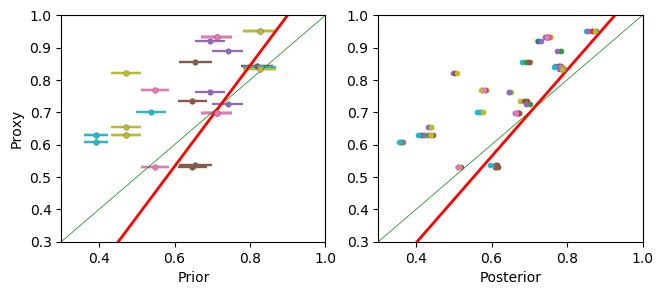

In [16]:
# correlation
# plot data-model comparison before and after DA
# show equation and line

plotn = 1

limoption = 'tex'

if limoption in ['tex']:
    lims = 0.3
    lime = 1.0
if limoption in ['o18']:
    lims = 0.3
    lime = 1.0
if limoption in ['mgca']:
    lims = 0.3
    lime = 6.0

stdtf = [True, False] # True: standardize; False: use raw analysis data
cetf = [False, True] # True: calculate ce in all; False: calculate ce for each time slice

for allcei in range(2):
    for stdi in range(2):
    
        allce = cetf[allcei]
        AnalysisStd = stdtf[stdi]

        if AnalysisStd:
            lim1 = -3
            ob_stat_select = np.copy(ob_std)
            xb_stat_select = np.copy(xb_std)
            xa_stat_select = np.copy(xa_std)
            print('standardized data used ')
            lim2 = -1 * lim1
        else:
            lim1 = lims
            lim2 = lime
            ob_stat_select = np.copy(ob_stat)
            xb_stat_select = np.copy(xb_stat)
            xa_stat_select = np.copy(xa_stat)
            print('raw data used ... ')
       
        if allce:
            print('  all time slice used ')
        else:
            print('  each time slice calculated ')

        if plotn > 0:

            for locRadi in range(locRadn):
                locRad = local_rad_list[locRadi]
                if locRad is None:
                    locRadv = 0 # for filename only
                else:
                    locRadv = locRad

                for proxy_fraci in range(proxy_fracn):
                    proxy_frac = proxy_frac_list[proxy_fraci]

                    for Rscalei in range(Rscalen):
                        Rscale = Rscale_list[Rscalei]
                        
                        if allce:
                            plt.rcParams.update({'figure.figsize':(10,2), 'figure.dpi':100})
                            fig = plt.figure(figsize=(7.5, 3), dpi=100)
                            for kki in range(2):
                                varyall = np.full((recon_period_len*sites_withhold_len), np.nan)
                                varxall = np.full((recon_period_len*sites_withhold_len), np.nan)
                                if kki == 0:
                                    subploti = 121
                                else:
                                    subploti = 122
                                plt.subplot(subploti)
                                plt.plot(np.array([lim1,lim2]), np.array([lim1,lim2]), color='green',linewidth=.5)
                                if kki == 0:
                                    # before DA
                                    plt.xlabel('Prior')
                                    plt.ylabel('Proxy')
                                    
                                    
                                    for ki in range(len(Typelist)):
                                        for reconi in range(recon_period_len):
                                            for MCi in range(MCn):
                                                ob_stat_selecti = ob_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][sites_eval.Type == Typelist[ki]]
                                                y1  = ob_stat_selecti.flatten('F')
                                                ye1 = ob_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi+1][sites_eval.Type == Typelist[ki]].flatten('F')
                                                x1  = xb_stat_select[locRadi][proxy_fraci][Rscalei][MCi][0][sites_eval.Type == Typelist[ki]]
                                                xe1 = xb_stat_select[locRadi][proxy_fraci][Rscalei][MCi][1][sites_eval.Type == Typelist[ki]]
                                                #plt.errorbar(x1, y1, xerr = np.sqrt(xe1), yerr=np.sqrt(ye1), ls = '', label = Typelist[ki])
                                                plt.errorbar(x1, y1, xerr = np.sqrt(xe1), marker='.', ls = '')
                                                # linear regression
                                                id1 = 0
                                                idn = id1+y1.size
                                                varxall[id1:idn] = np.copy(x1)
                                                varyall[id1:idn] = np.copy(y1)
                                                id1 = idn

                                else:
                                    # after DA
                                    plt.xlabel('Posterior')
                                    for ki in range(len(Typelist)):
                                        for reconi in range(recon_period_len):
                                            for MCi in range(MCn):
                                                x1  = xa_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][sites_eval.Type == Typelist[ki]]
                                                xe1 = xa_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi+1][sites_eval.Type == Typelist[ki]]
                                                y1  = ob_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][sites_eval.Type == Typelist[ki]]
                                                ye1 = ob_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi+1][sites_eval.Type == Typelist[ki]]
                                                #plt.errorbar(x1, y1, xerr = np.sqrt(xe1), yerr=np.sqrt(ye1), ls = '', label = Typelist[ki])
                                                plt.errorbar(x1, y1, xerr = np.sqrt(xe1), marker='.', ls = '')

                                                id1 = 0
                                                idn = id1+y1.size
                                                varxall[id1:idn] = np.copy(x1)
                                                varyall[id1:idn] = np.copy(y1)
                                                id1 = idn

                                mask = ~np.isnan(varxall) & ~np.isnan(varyall)
                                slope, intercept, r_value, p_value, std_err = stats.linregress(varxall[mask], varyall[mask])
                                textstr = ('y = {:.3f} * x + {:.3f} \n r = {:.3f}'.format(slope, intercept,r_value))
                                #plt.text(1, 3, textstr, wrap=True)
                                plt.xlim(lim1,lim2)
                                plt.ylim(lim1,lim2)
                                
                                plt.plot(np.array([lim1,lim2]), np.array([lim1*slope+intercept,lim2*slope+intercept]), color='red',linewidth=2)
                                #plt.legend();
                        else:

                            plt.rcParams.update({'figure.figsize':(10,2), 'figure.dpi':100})

                            for reconi in range(recon_period_len):
                                fig = plt.figure(figsize=(7.5, 3), dpi=100)
                                
                                for kki in range(2):
                                    if kki == 0:
                                        subploti = 121
                                    else:
                                        subploti = 122
                                    plt.subplot(subploti)
                                    plt.plot(np.array([lim1,lim2]), np.array([lim1,lim2]), color='green',linewidth=.5)
                                    for MCi in range(MCn):
                                        if kki == 0:
                                            # before DA
                                            plt.xlabel('Prior')
                                            plt.ylabel('Proxy ' + label_all[reconi])
                                            for ki in range(len(Typelist)):
                                                x1  = xb_stat_select[locRadi][proxy_fraci][Rscalei][MCi][0][sites_eval.Type == Typelist[ki]]
                                                xe1 = xb_stat_select[locRadi][proxy_fraci][Rscalei][MCi][1][sites_eval.Type == Typelist[ki]]
                                                y1  = ob_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][sites_eval.Type == Typelist[ki]]
                                                ye1 = ob_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi+1][sites_eval.Type == Typelist[ki]]
                                                #plt.errorbar(x1, y1, xerr = np.sqrt(xe1), yerr=np.sqrt(ye1), ls = '', label = Typelist[ki])
                                                plt.errorbar(x1, y1, xerr = np.sqrt(xe1), marker='.', ls = '')
                                                # linear regression
                                            varx = xb_stat_select[locRadi,proxy_fraci,Rscalei,MCi,0,:]
                                            vary = ob_stat_select[locRadi,proxy_fraci,Rscalei,MCi,2*reconi,:]
                                                #mask = ~np.isnan(varx) & ~np.isnan(vary)
                                                #slope, intercept, r_value, p_value, std_err = stats.linregress(varx[mask], vary[mask])
                                        else:
                                            # after DA
                                            plt.xlabel('Posterior')
                                            for ki in range(len(Typelist)):
                                                x1  = xa_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][sites_eval.Type == Typelist[ki]]
                                                xe1 = xa_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi+1][sites_eval.Type == Typelist[ki]]
                                                y1  = ob_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][sites_eval.Type == Typelist[ki]]
                                                ye1 = ob_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi+1][sites_eval.Type == Typelist[ki]]
                                                #plt.errorbar(x1, y1, xerr = np.sqrt(xe1), yerr=np.sqrt(ye1), ls = '', label = Typelist[ki])
                                                plt.errorbar(x1, y1, xerr = np.sqrt(xe1), marker='.', ls = '')
                                                # linear regression
                                            varx = xa_stat_select[locRadi,proxy_fraci,Rscalei,MCi,2*reconi,:]
                                            vary = ob_stat_select[locRadi,proxy_fraci,Rscalei,MCi,2*reconi,:]

                                    mask = ~np.isnan(varx) & ~np.isnan(vary)
                                    slope, intercept, r_value, p_value, std_err = stats.linregress(varx[mask], vary[mask])
                                    textstr = ('y = {:.3f} * x + {:.3f} \n r = {:.3f}'.format(slope, intercept,r_value))
                                    #plt.text(1, 3, textstr, wrap=True)
                                    plt.xlim(lim1,lim2)
                                    plt.ylim(lim1,lim2)
                                    plt.plot(np.array([lim1,lim2]), np.array([lim1*slope+intercept,lim2*slope+intercept]), color='red',linewidth=2)
                                    plt.legend();
# export jupyter notebook as html, for reference
os.system('jupyter nbconvert --to html DeepDA_verify.ipynb')
shutil.move("DeepDA_verify.html", MC_dir+"DeepDA_verify_proxyunit.html")